# Intro
## SVM: 튜토리얼
본 실습 파일은 직접 Hard & Soft margin SVM을 구현해 보고, 각종 실험 및 시각화를 통해 기본적인 SVM에서 부터 Kernel trick까지 개념의 이해를 깊게하기 위한 튜토리얼이다.

위 목적을 달성하기 위해 아래와 같은 내용을 포함한다.
   1. 기본적인 이론을 복습
   2. Hard & Soft margin SVM 구현
   3. 각 SVM의 특징을 파악하기 좋은 실험 데이터를 직접 생성하여 각종 실험 수행
   4. Linearly separable 하지않은 데이터에 kernel trick의 의미 확인
   5. 다양한 kernel 구현 및 라이브러리를 통한 비교 실험 수행

# 0. 필수 라이브러리 및 실험용 데이터 생성

In [5]:
import numpy as np  # for handling multi-dimensional array operation
import pandas as pd  # for reading data from csv  
import random
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import matplotlib
# plt.rcParams['font.family'] = 'NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] = False

## 0.1 실험을 위한 데이터셋 생성
추후 구현한 코드에 대한 실험을 수행하기 위해 반지름이 다른 두개의 원의 분포를 가지는 데이터를 생성하는 함수를 작성하였다.

In [6]:
# generate data
def genrate_circle_data(r, x, y, n:int):
    """
    r: radius of the circle
    x: x-coordinate of the center of the circle
    y: y-coordinate of the center of the circle
    n: number of data points
    """
    data = []
    for i in range(n):
        angle = random.uniform(0, 2*math.pi)
        data.append([r*math.cos(angle)+x, r*math.sin(angle)+y])
    return data


# 1. 이론 복습
우선 SVM을 직접 구현하는 것 부터 시작해 보자.  
SVM을 알고 있듯이 기본적으로는 선형 분류기 이며, 오차를 허용하는 지 여부에 따라 Hard margin과 Soft margin SVM으로 나뉘고  
오늘의 주제인 kernel trick의 사용여부에 따라 Linearly non-separable 데이터에 대한 분류 가능여부가 결정된다.  
다음은 그 분류를 표로 나타낸 것이다.  
<p align="center">
  <image src=".\images\2022-11-03-13-56-24.png" height="200"/>  
</p>

이번 실습에서는 case1 부터 case3까지 순서대로 모델을 확장해 나가는 방식으로 모든 모델에 대해 설명하고 최종적으로 구현해 보고자 한다.

## 1.0 Basics
바로 SVM 구현으로 들어가기에 앞서 SVM이 무엇인지 한번 가볍게 짚고 넘어가 보자.  
SVM은 이진 선형 분류기로써 D-dimension에서 두 범주를 잘 구분하는 (d-1) 차원의 hyperplane을 찾는 방법론이다.  

그를 실현하기 SVM은 "분류 경계면에서 가장 가까운 양쪽 범주 객체와의 거리"인 margin을 최대화 하는 것을 목적으로 하며  
Margin을 최대화 하는 경우에 Structural Risk Minimization 관점에서 구조적 위험이 최소화된다는 것이 증명되어 있다.  
이를 다음의 그림에서 A경계면이 B경계면 보다 큰 마진을 가지기 때문에 선호된다는 의미이며,  
Noise robustness 관점에서도 margin이 큰 경우가 더 나은 모델이라고 직관적으로 이해가 가능하다.  

<p align="center">
  <image src="images\2022-11-03-14-13-55.png" height="310"/>  
</p>

그렇다면 이러한 margin을 어떻게 구할 수 있을 까?  
다음의 그림을 살펴보자.  
<p align="center">
  <image src="images\2022-11-03-14-05-02.png" height="200"/>  
</p>
위 그림에서 푸른색이 분류 경계면 이며, 초록색은 margin이 만나는 점이 존재하는 평면을 의미한다.  

이때, x_{0}를 분류경계면 위의 점, x_{1}을 마진 위의 점이라고 할때,  
우측의 식에서 처럼 간단하게 margin의 크기를 계산할 수 있다.  

margin의 크기를 분류경계면에서 한쪽의 객체까지 만나는 거리로 정의하는 경우도, 양쪽 방향을 모두 더하여 정의하는 경우도 모두 가능하나 이번 튜토리얼에서는 양쪽을 더한 경우로 정의하기로 한다.(분자가 2)

## 1.1 Case1-Linear & Hard Margin
가장 기본적인 예외를 허용하지 않는 hard 마진의 경우 다음과 같은 최적화 식으로 표현이 가능하다.  
<p align="center">
  <image src="images\2022-11-03-14-22-21.png" height="310"/>  
</p>
margin을 최대화 한다는 목적식은 그 역수를 최소화 하는 식으로 변경되었으며,  
모든 점이 margin보다 멀리 떨어져 있어야 한다는 제약식으로 정리가 되었다.  

여기서 분류경계면 위, 아래에 대한 제약식이 하나의 식으로 정리가 될 수 있는 이유는 그림에도 나와있는 것처럼 각 범주의 label을 0, 1이 아닌 -1, +1로 했기 때문이다.

이 최적화 식의 경우 Lagrangian multiplier, KKT condition, Dual의 과정을 거쳐 가능하며, 이번 실습에서는 SGD 방식을 통해 최적화 하였다.  
<p align="center">
  <image src="images\2022-11-03-14-33-53.png" height="90"/>  
</p>

# 1.2 Case2 - Linear & Soft Margin
두 번째로 이야기할 case2는 데이터가 완전히 linearly separable하지 않은 경우를 위한 것이다.  
다음의 그림처럼 예외를 허용하지 않으면 경계를 만들지 못하는 상황 존재하고, 이 경우 penalty를 주는 대신 마진을 넘어가는 예외를 허용하는 경계면을 만들 수 있다
<p align="center">
  <image src="images\2022-11-03-14-37-15.png" height="300"/>  
</p>
이 경우도 마찬가지로 목적은 margin을 최대화 하는 것으로 목적식이 거의 그대로 유지된다. 
<p align="center">
  <image src="images\2022-11-03-14-42-23.png" height="300"/>  
</p>
식을 보면 알겠지만, 거의 그대로 유지되며 margin을 최대화하는 것 이외에 예외를 허용하지만 그 정도를 최소화 하기위한 term이 추가 되었다.  
제약식의 경우에도 거의 유지되며 예외의 경우 margin으로 부터 오차만큼만 벗어난다는 term이 추가되었다.

case2도 마찬가지로 Lagrangian multiplier를 사용해 original 문제를 다음과 같이 변형할 수 있으며 그 식은 다음과 같다.

<p align="center">
  <image src="images\2022-11-03-14-43-54.png" height="90"/>  
</p>


***식에서 알 수 있듯이 Case1 & Case2의 경우 거의 동일한 식의 구조를 가지고 있으며, Soft margin의 경우가 Hard margin의 확장판 같은 의미이기 때문에 한번에 코드로 구현할 수 가 있다.***

원 논문에서는 hindge loss를 사용하지 않았으나 최근에는 해당 loss를 사용하는 것이 좋다고 알려져 있으므로 hindge loss를 사용하여 구현해보자.


# 2. Hard & Soft margin SVM 코드 구현

먼저 예측값과 실제값 사이 차이를 활용한 hindge loss를 정의하고 최적화 대상인 목적식을 loss의 형태로 계산한다.

In [ ]:
# compute loss
def compute_loss(X, y, w, C, b):
    N = X.shape[0] # number of samples
    # hinge loss
    hinge_loss = np.maximum(0, 1 - y * (np.dot(X, w) + b))
    # regularization
    reg_loss = 0.5 * np.dot(w, w)
    # total loss
    loss = reg_loss + C * (np.sum(hinge_loss)/N)
    return loss

다음으로는 w와 b에 대한 각각의 gradient를 계산하는 함수를 정의한다. 계산과정은 위에 설명한 내용과 동일하다.

In [177]:
def compute_gradient(X_batch, Y_batch, w, b, C):
    N = X_batch.shape[0]
    grad_w = np.zeros(w.shape)
    grad_b = 0
    for i in range(N):
        if Y_batch.iloc[i] * (np.dot(X_batch.iloc[i], w) + b) < 1:
            grad_w += -C * Y_batch.iloc[i] * X_batch.iloc[i]
            grad_b += -Y_batch.iloc[i]
    grad_w = w + C * grad_w / N
    grad_b = C * grad_b / N
    return grad_w, grad_b

마지막으로 학습을 위한 train함수와 성능 확인을 위한 accuracy함수를 정의한다.

In [178]:
# compute accuracy
def compute_accuracy(X, y, w, b):
    y_pred = np.sign(np.dot(X, w) + b)
    accuracy = accuracy_score(y, y_pred)
    return accuracy

# train model
def train(X_train, y_train, X_val, y_val, learning_rate, C, num_epochs):
    weights_list = []
    bias_list = []
    weights = np.zeros(X_train.shape[1])
    bias = 0
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        # shuffle data
        X_train, y_train = shuffle(X_train, y_train)
        
        grad_w, grad_b = compute_gradient(X_train, y_train, weights, bias, C)
        # update parameters
        weights = weights - learning_rate * grad_w
        bias = bias - learning_rate * grad_b

        train_loss.append(compute_loss(X_train, y_train, weights, C, bias))
        val_loss.append(compute_loss(X_val, y_val, weights, C, bias))
        train_acc.append(compute_accuracy(X_train, y_train, weights, bias))
        val_acc.append(compute_accuracy(X_val, y_val, weights, bias))
        weights_list.append(weights)
        bias_list.append(bias)
        
        if epoch % 10 == 0:
            print('Epoch: {:03d}, Train Loss: {:.3f}, Train Acc: {:.3f}, Val Loss: {:.3f}, Val Acc: {:.3f}'.format(
                epoch, train_loss[epoch], train_acc[epoch], val_loss[epoch], val_acc[epoch]))
    return weights, bias, train_loss, val_loss, train_acc, val_acc, weights_list, bias_list

## 2.1 구현한 코드 실험

### 2.1.1 Hard Margin

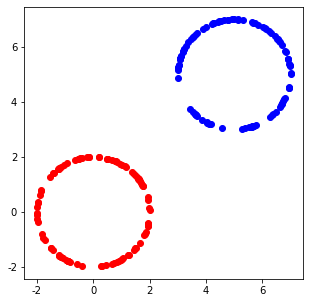

In [147]:
# 실험 데이터 생성
a=genrate_circle_data(2, 0, 0, 100)
b=genrate_circle_data(2, 5, 5, 100)
plt.figure(figsize=(5,5))
plt.scatter([i[0] for i in a], [i[1] for i in a], color='red')
plt.scatter([i[0] for i in b], [i[1] for i in b], color='blue')
plt.show()

data= pd.DataFrame(a+b, columns=['x', 'y'])
data['label'] = [-1]*len(a) + [1]*len(b)

위에서 만든 이 범주 데이터를 train, validation set으로 구분하여 학습에 사용하자

In [148]:
X = data[['x', 'y']]
y = data['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

앞서 정의한 train 함수를 통해 다음과 같이총 500번의 epoch 만큼 학습을 수행한다.  

penalty term을 조절하는 C의 경우는 이번 테스트 환경에서는 linearly peparable하기 때문에 우선은 그냥 10으로 고정하여 실험을 수행하였다.

In [ ]:
weights, bias, train_loss, val_loss, train_acc, val_acc, weights_list, bias_list=train(X_train, y_train, X_val, y_val, 0.01, 10, 500)

다음은 학습이 진행되는 과정동안 분류 경계면의 변화를 나타낸 그림이다.  
우리가 목적한 대로 margin이 점점 커지는 방향으로 학습이 수행되며, 최종적으로 정확도가 1.0인 모델을 얻는다.

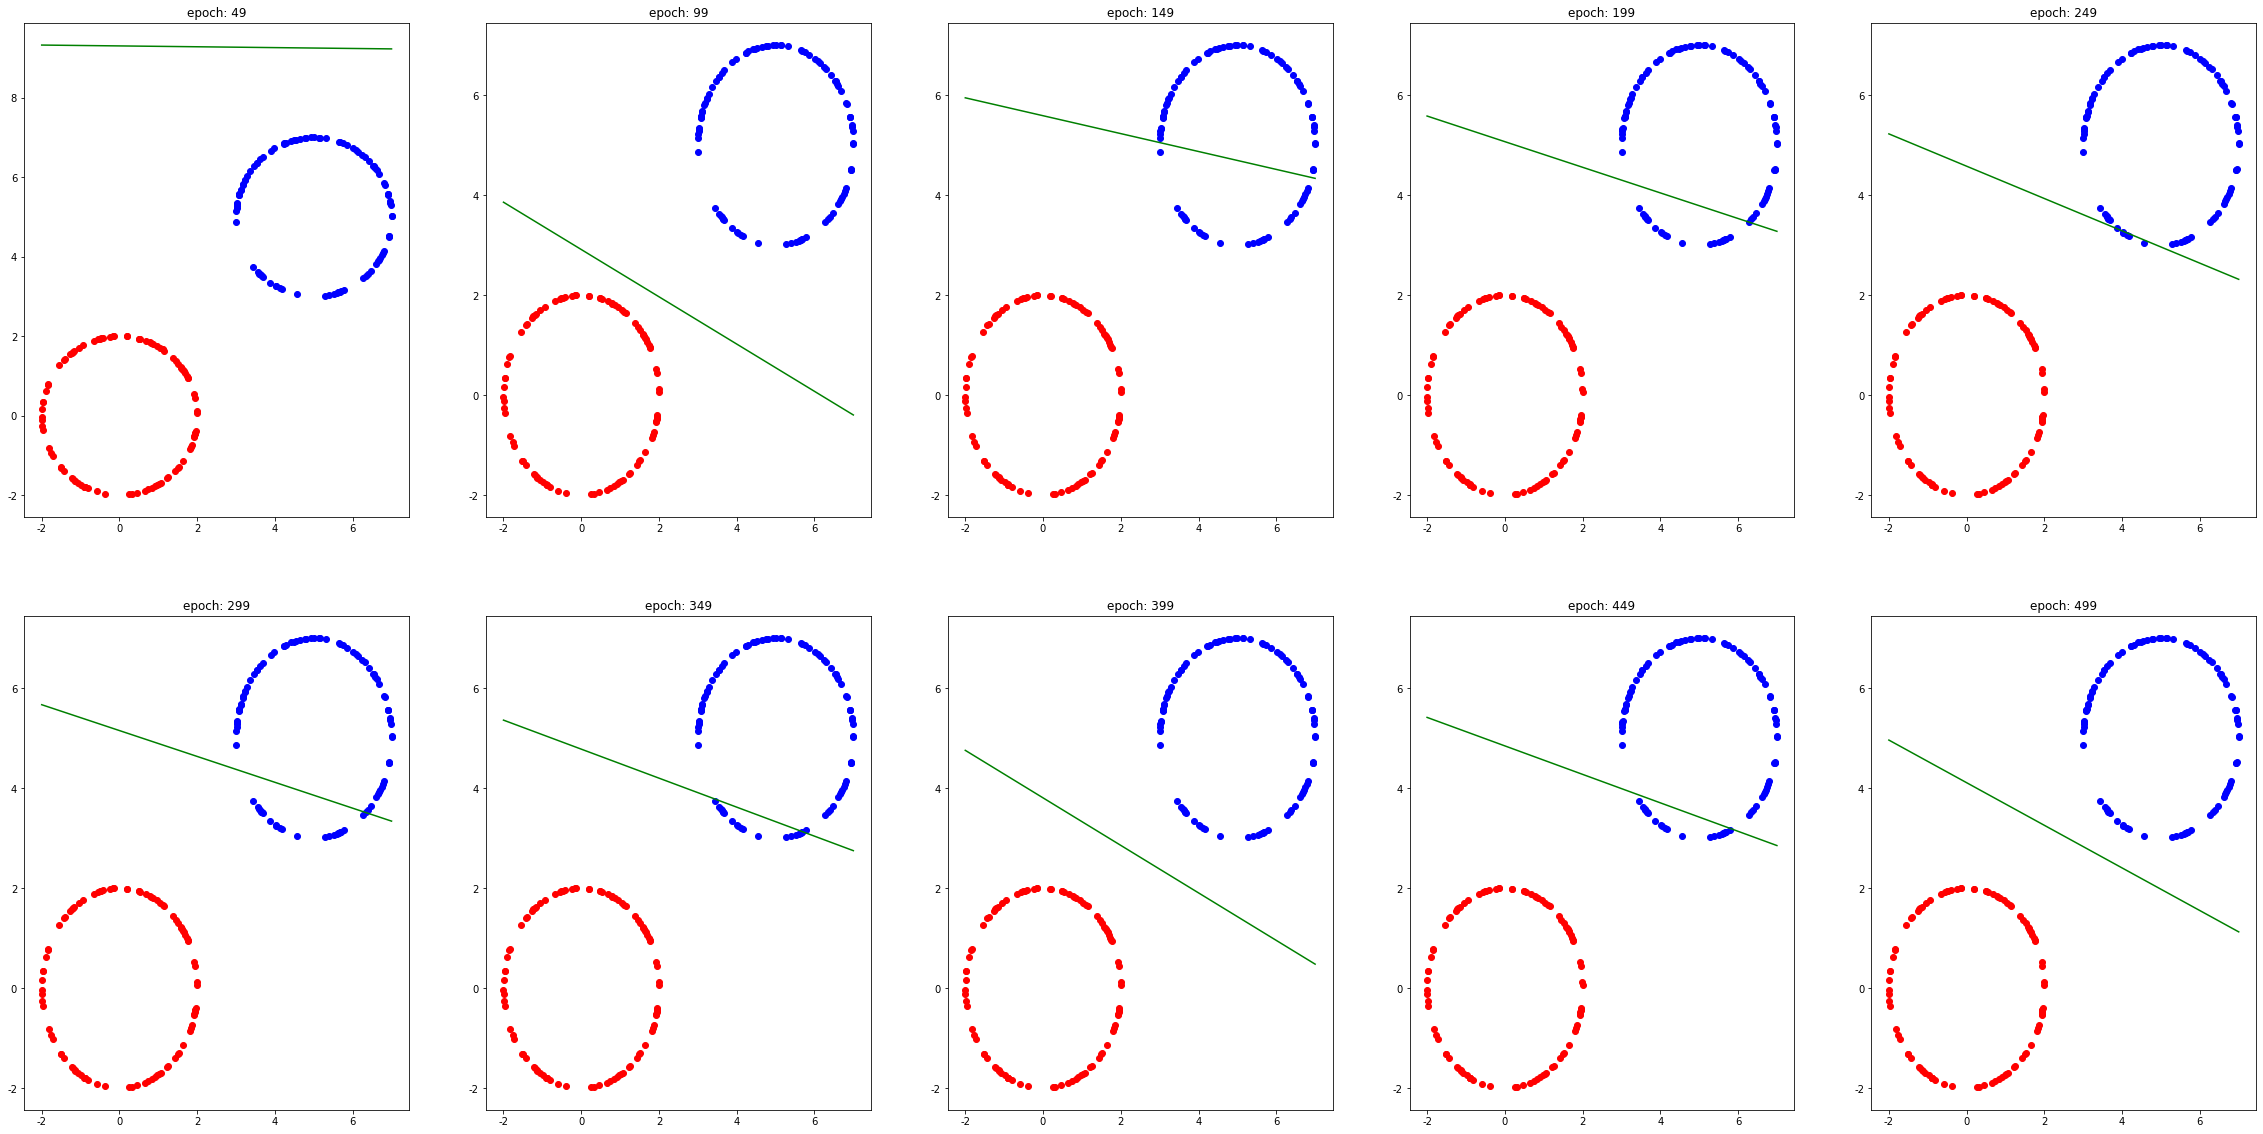

In [175]:
line=np.array(range(-2, 8))

# 그래프 배경화면 만들기
f, axs = plt.subplots(2,5,figsize=(40,20))

# 그래프 그리기
for i in range(10):
    j=(i+1)*50-1
    axs[int(i//5), int(i%5)].scatter([i[0] for i in a], [i[1] for i in a], color='red')
    axs[int(i//5), int(i%5)].scatter([i[0] for i in b], [i[1] for i in b], color='blue')
    axs[int(i//5), int(i%5)].plot(line, (-weights_list[j][0]*weights_list[j][1])*line-bias_list[j]/weights_list[j][1], color='green')
    axs[int(i//5), int(i%5)].set_title('epoch: '+str(j))



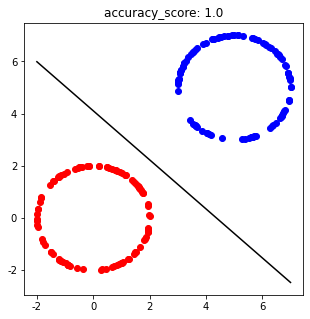

In [155]:
plt.figure(figsize=(5,5))
plt.scatter([i[0] for i in a], [i[1] for i in a], color='red')
plt.scatter([i[0] for i in b], [i[1] for i in b], color='blue')
plt.plot(line, (-weights[0]/weights[1])*line-bias/weights[1], color='black')
plt.title(f'accuracy_score: 1.0')
plt.show()

### 2.1.2 Soft margin
위의 간단한 데이터의 실험을 통해 SVM 모델이 올바르게 작동하는 것을 확인하였으니 이제 조금더 복잡한 데이터를 활용해 실험을 수행해 보자. 다음 데이터는 앞서 사용한 예시와 동일하게 두개의 원 형태의 데이터이나, 둘사이의 거리가 더 가깝고 noise를 포함하려 조금씩 겹치는 경우이다.

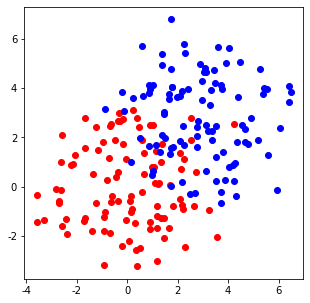

In [222]:
# 실험 데이터 생성
a=np.array(genrate_circle_data(2, 0, 0, 100))
b=np.array(genrate_circle_data(2, 3, 3, 100))

a=a+np.random.standard_normal(a.shape)
b=b+np.random.standard_normal(b.shape)
plt.figure(figsize=(5,5))
plt.scatter([i[0] for i in a], [i[1] for i in a], color='red')
plt.scatter([i[0] for i in b], [i[1] for i in b], color='blue')
plt.show()

data= pd.DataFrame(np.concatenate((a,b)), columns=['x', 'y'])
data['label'] = [-1]*len(a) + [1]*len(b)

위 그래프를 보면 파란색과 빨란색의 데이터가 서로 겹쳐진 부분이 존재해, 기본적인 hard margin SVM으로는 완벽한 분류가 불가능 할 것을 예상가능하다. 때문에 이번에는 예외를 허용하는 sofr margin SVM을 활용해 실험을 수행해 보자.  

실험을 수행하는 과정인 직전과 동일하므로 한번에 실험을 수행해 보면 다음과 같다.

In [ ]:
X = data[['x', 'y']]
y = data['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

weights, bias, train_loss, val_loss, train_acc, val_acc, weights_list, bias_list=train(X_train, y_train, X_val, y_val, 0.01, 10, 500)

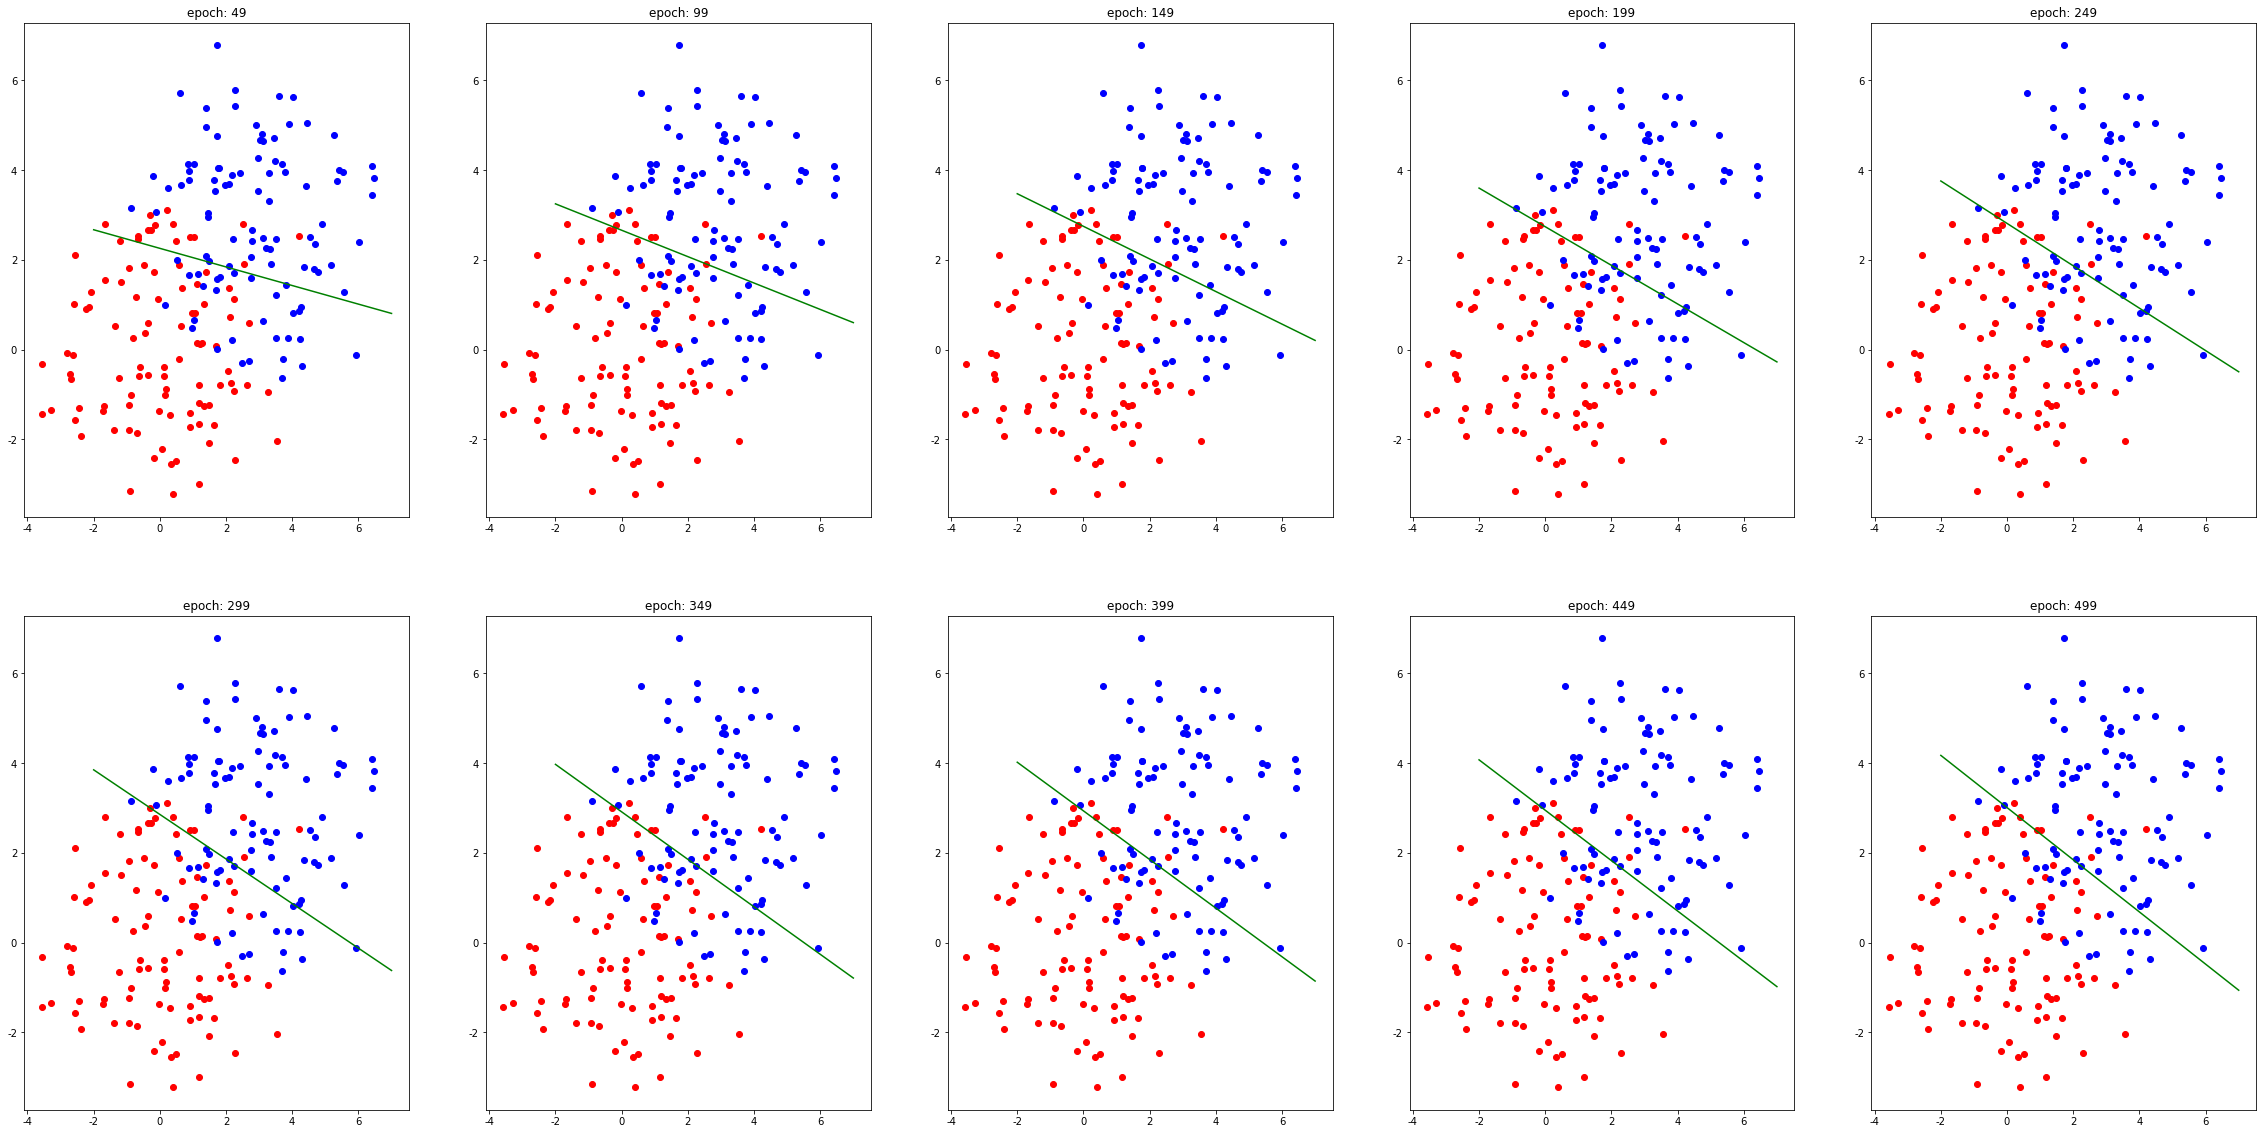

In [224]:
line=np.array(range(-2, 8))

# 그래프 배경화면 만들기
f, axs = plt.subplots(2,5,figsize=(40,20))

# 그래프 그리기
for i in range(10):
    j=(i+1)*50-1
    axs[int(i//5), int(i%5)].scatter([i[0] for i in a], [i[1] for i in a], color='red')
    axs[int(i//5), int(i%5)].scatter([i[0] for i in b], [i[1] for i in b], color='blue')
    axs[int(i//5), int(i%5)].plot(line, (-weights_list[j][0]*weights_list[j][1])*line-bias_list[j]/weights_list[j][1], color='green')
    axs[int(i//5), int(i%5)].set_title('epoch: '+str(j))

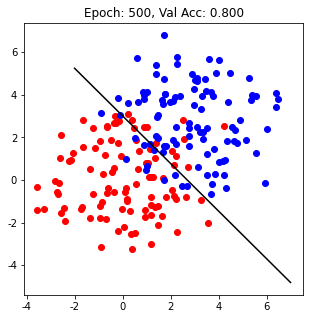

In [227]:
plt.figure(figsize=(5,5))
plt.scatter([i[0] for i in a], [i[1] for i in a], color='red')
plt.scatter([i[0] for i in b], [i[1] for i in b], color='blue')
plt.plot(line, (-weights[0]/weights[1])*line-bias/weights[1], color='black')
plt.title(f'Epoch: {len(val_acc):03d}, Val Acc: {val_acc[-1]:.3f}')

plt.show()

위 그래프를 보면 완벽하게 분류는 해내지 못하지만 예외를 최소한으로 유지하며 그 안에서 마진을 최대화 한 것을 볼 수가 있다.  

이때의 Acc는 0.8로 현재 데이터 상황에서 선형 분류기로써 나쁘지 않은 성능을 보인다.  

이렇게 예외를 허용하는 soft margin SVM의 경우 penalty의 정도를 조절하는 C가 Hyper-parameter이다.  


**다음은 그 C의 크기에 따른 분류경계면을 비교해 보기위한 실험이다.**

### 2.1.3 C에 따른 분류경계면

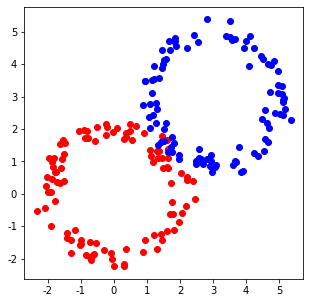

In [232]:
# C에 따른 분류 경계면을 비교하기 좋게 겹치는 부분이 조금 더 적은 데이터를 생성
a=np.array(genrate_circle_data(2, 0, 0, 100))
b=np.array(genrate_circle_data(2, 3, 3, 100))

a=a+np.random.standard_normal(a.shape)/5
b=b+np.random.standard_normal(b.shape)/5
plt.figure(figsize=(5,5))
plt.scatter([i[0] for i in a], [i[1] for i in a], color='red')
plt.scatter([i[0] for i in b], [i[1] for i in b], color='blue')
plt.show()

data= pd.DataFrame(np.concatenate((a,b)), columns=['x', 'y'])
data['label'] = [-1]*len(a) + [1]*len(b)

C를 [0.001, 0.01, 0.1, 1, 5, 10, 30,  80, 100, 300] 안에서 변경 해가며 모델을 학습

In [ ]:
X = data[['x', 'y']]
y = data['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

C_list = [0.001, 0.01, 0.1, 1, 5, 10, 30,  80, 100, 300]
val_acc_list=[]
weights_C_list=[]
bias_C_list=[]

for C in C_list:
    weights, bias, train_loss, val_loss, train_acc, val_acc, weights_list, bias_list=train(X_train, y_train, X_val, y_val, 0.01, C, 500)
    val_acc_list.append(val_acc[-1])
    weights_C_list.append(weights)
    bias_C_list.append(bias)

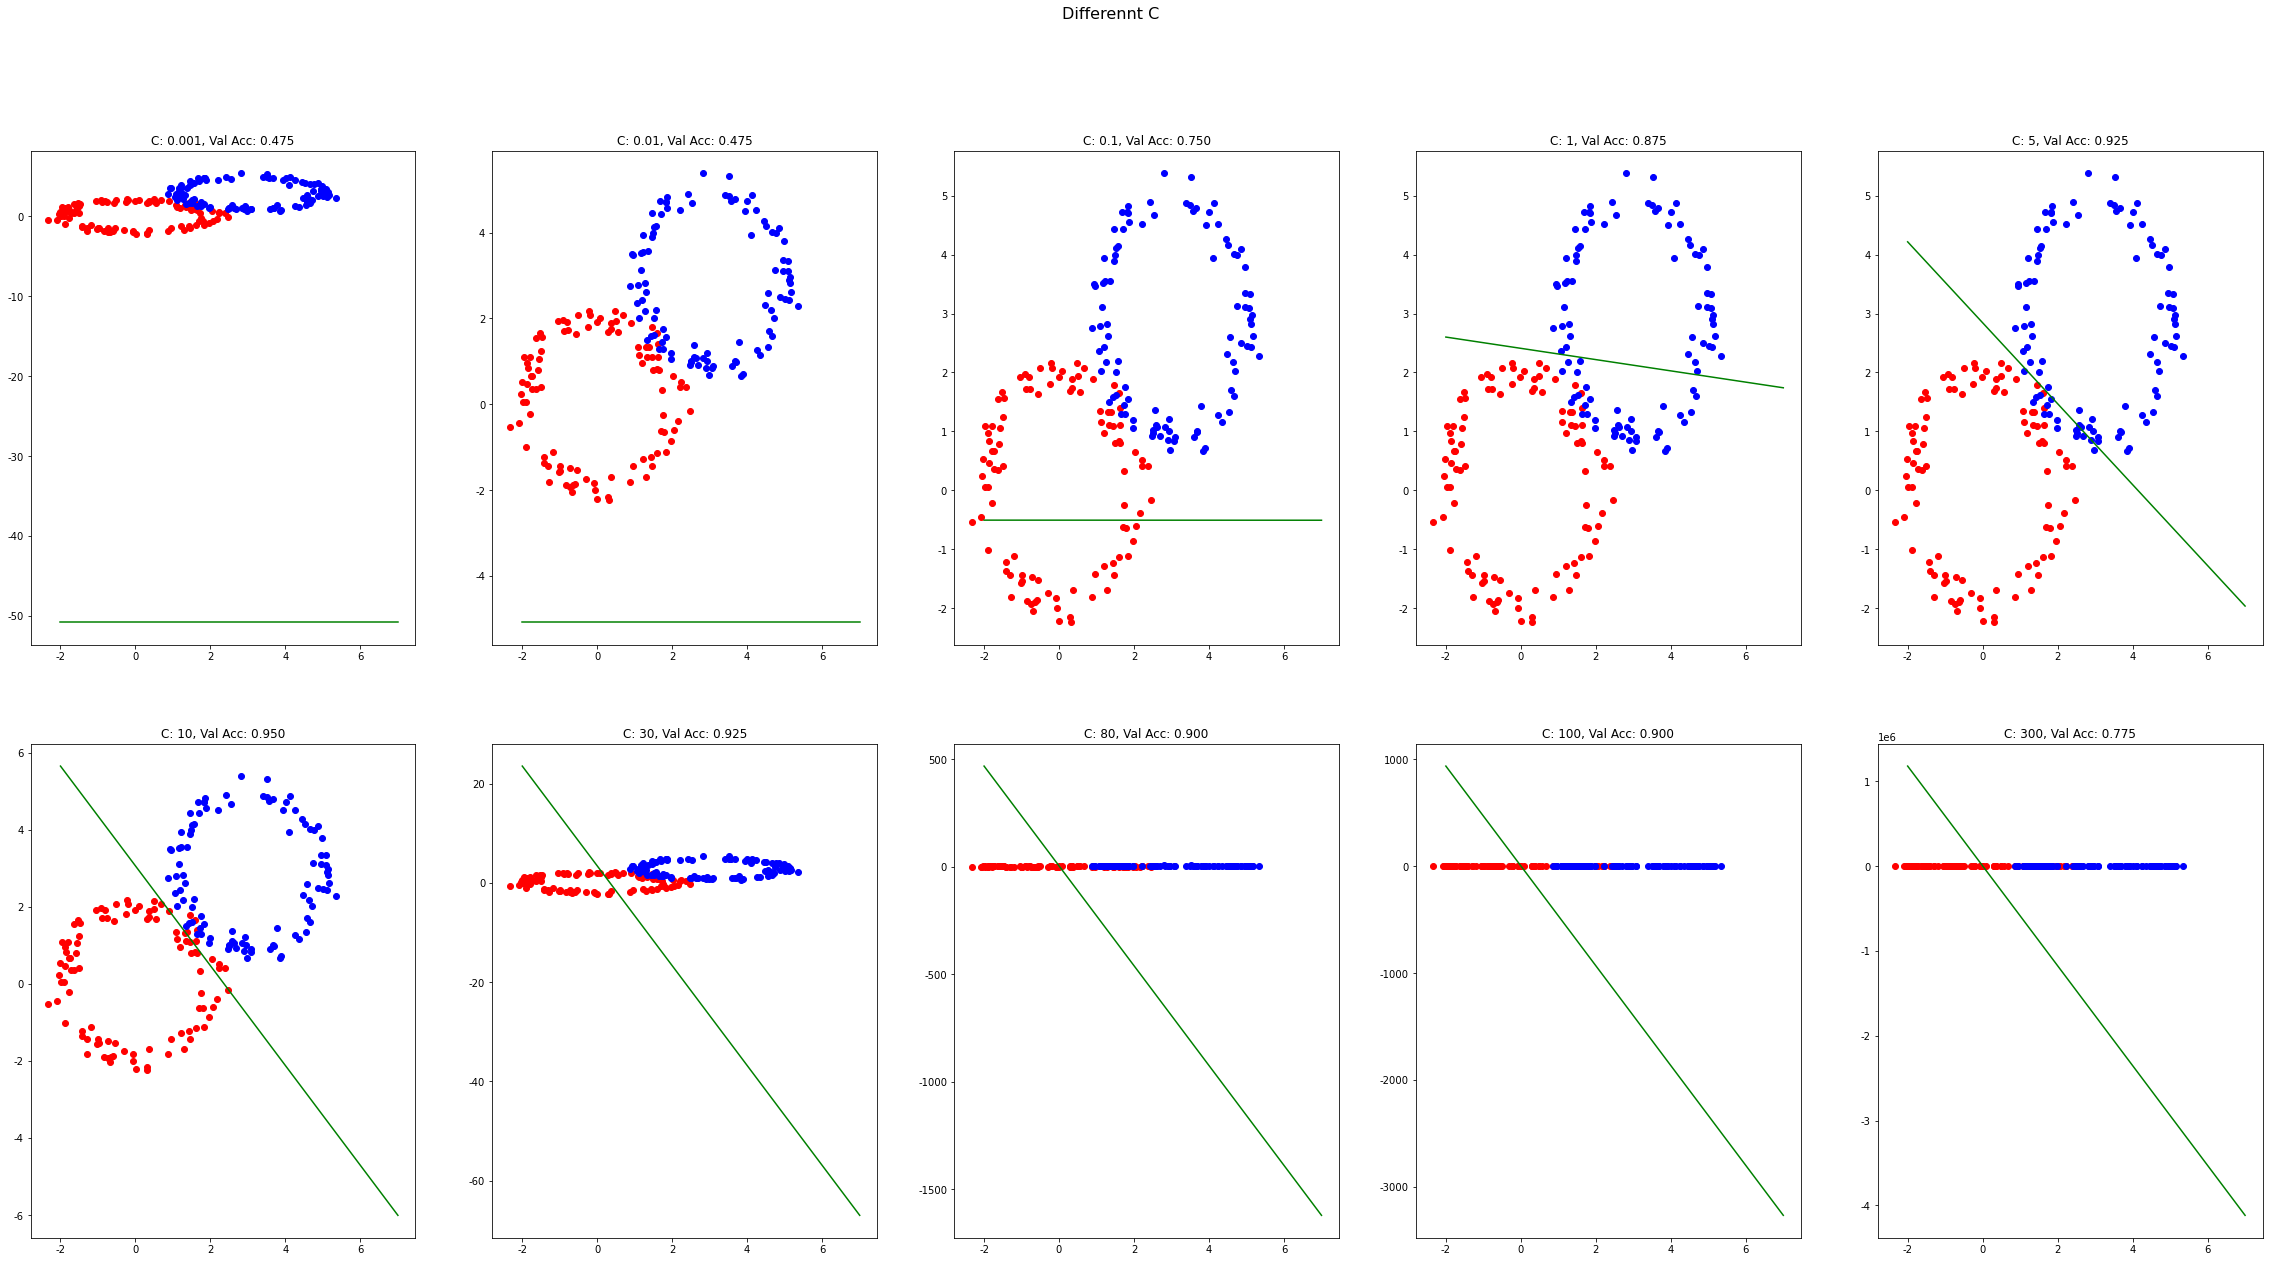

In [256]:
line=np.array(range(-2, 8))

# 그래프 배경화면 만들기
f, axs = plt.subplots(2,5,figsize=(40,20))

# 그래프 그리기
for i in range(10):
    axs[int(i//5), int(i%5)].scatter([i[0] for i in a], [i[1] for i in a], color='red')
    axs[int(i//5), int(i%5)].scatter([i[0] for i in b], [i[1] for i in b], color='blue')
    axs[int(i//5), int(i%5)].plot(line, (-weights_C_list[i][0]*weights_C_list[i][1])*line-bias_C_list[i]/weights_C_list[i][1], color='green')
    axs[int(i//5), int(i%5)].set_title(f'C: {C_list[i]}, Val Acc: {val_acc_list[i]:.3f}')

f.suptitle('Differennt C', fontsize=16)

plt.show()

위 비교 그래프를 보면 C에 따라서 전혀 다른 분류 경계 면을 가지게 되며, 데이터에 따라 적절한 크기의 C가 존재한다는 것을 알 수 있다.  
다음으론 붉은색의 수가 파란색의 수보다 훨씬 많은 경우이다. 

In [ ]:
# C에 따른 분류 경계면을 비교하기 좋게 겹치는 부분이 조금 더 적은 데이터를 생성
a=np.array(genrate_circle_data(2, 0, 0, 500))
b=np.array(genrate_circle_data(2, 3, 3, 100))

a=a+np.random.standard_normal(a.shape)/2
b=b+np.random.standard_normal(b.shape)/2


data= pd.DataFrame(np.concatenate((a,b)), columns=['x', 'y'])
data['label'] = [-1]*len(a) + [1]*len(b)

X = data[['x', 'y']]
y = data['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

C_list = [0.1, 1, 5, 10, 30]
val_acc_list=[]
weights_C_list=[]
bias_C_list=[]

for C in C_list:
    weights, bias, train_loss, val_loss, train_acc, val_acc, weights_list, bias_list=train(X_train, y_train, X_val, y_val, 0.01, C, 200)
    val_acc_list.append(val_acc[-1])
    weights_C_list.append(weights)
    bias_C_list.append(bias)

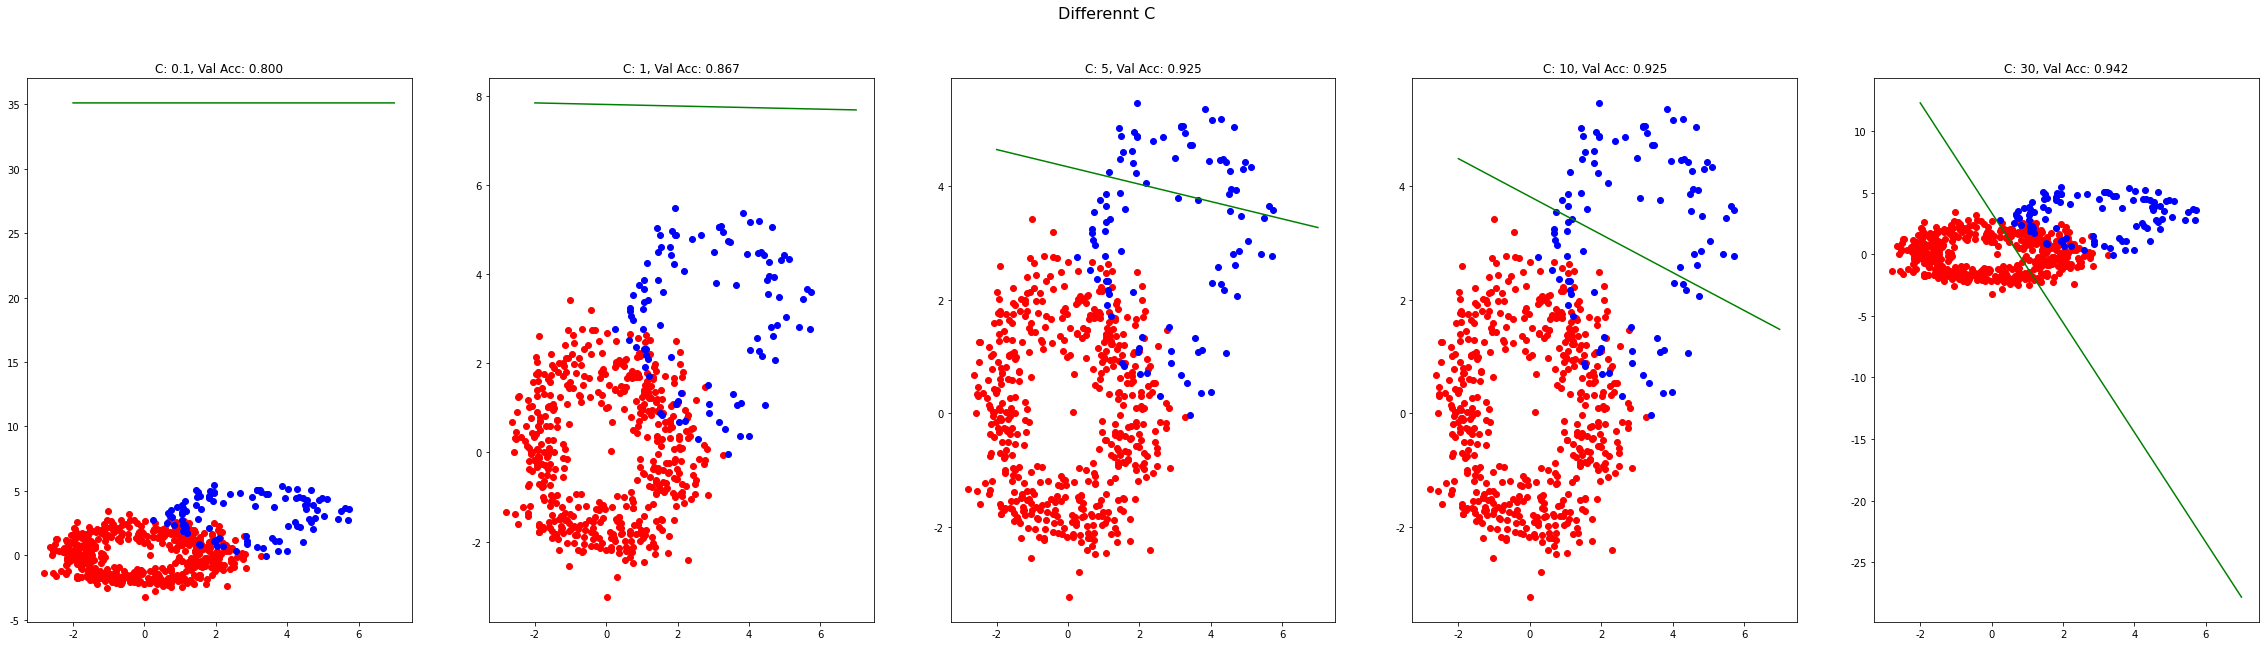

In [263]:
line=np.array(range(-2, 8))

# 그래프 배경화면 만들기
f, axs = plt.subplots(1,5,figsize=(40,10))

# 그래프 그리기
for i in range(len(C_list)):
    axs[int(i%5)].scatter([i[0] for i in a], [i[1] for i in a], color='red')
    axs[int(i%5)].scatter([i[0] for i in b], [i[1] for i in b], color='blue')
    axs[int(i%5)].plot(line, (-weights_C_list[i][0]*weights_C_list[i][1])*line-bias_C_list[i]/weights_C_list[i][1], color='green')
    axs[int(i%5)].set_title(f'C: {C_list[i]}, Val Acc: {val_acc_list[i]:.3f}')

f.suptitle('Differennt C', fontsize=16)

plt.show()

위 처럼 C가 작을 수록 훨씬 숫자가 많은 붉은색의 오류가 더 적을 수 있도록 분류 경계면이 만들어 지고 있다.  

C에 변화에 따른 허용 Penalty 정도와 Margin은 다음과 같이 정리할 수 있다.
<p align="center">
  <image src="images\2022-11-03-20-25-18.png" height="100"/>  
</p>  

# 3. Kernel Trick
Linearly separable 하지않은 데이터를 선형으로 분리해 내는 방법에 대한 탐구

다음의 데이터는 중심이 같고 반지름의 길이가 다른 두 개의 원이 함께 존재하는 경우로 선형으로는 분류가 불가능한 데이터이다.

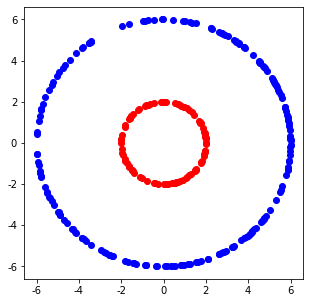

In [265]:
a=genrate_circle_data(2, 0, 0, 100)
b=genrate_circle_data(6, 0, 0, 200)
data= pd.DataFrame(a+b, columns=['x', 'y'])
data['label'] = [0]*len(a) + [1]*len(b)

plt.figure(figsize=(5,5))
plt.scatter([i[0] for i in a], [i[1] for i in a], color='red')
plt.scatter([i[0] for i in b], [i[1] for i in b], color='blue')
plt.show()

## 3.1 일반적인 선형 분류기(Linear Regression & Soft margin SVM)의 경우
아래의 그림에서 확인 할 수 있듯이 현재의 상황에서는 제대로 분류해 낼 수가 없다

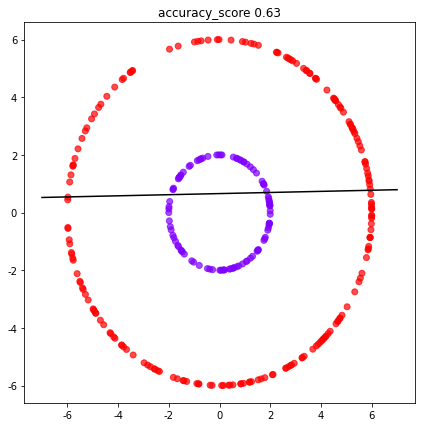

In [266]:
# Linear Regression
from sklearn.linear_model import LinearRegression

X = data[['x', 'y']]
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred = [1 if i>0.5 else 0 for i in y_pred]

a=np.array(range(-7, 8))

plt.figure(figsize=(7,7))
plt.scatter(X['x'], X['y'], c=y,cmap='rainbow', alpha=0.7)
plt.plot(a,model.coef_[0]*a+model.intercept_, color='black')
plt.title(f'accuracy_score {accuracy_score(y_test, y_pred):.2f}')
plt.show()

In [ ]:
# Soft margin SVM
a=genrate_circle_data(2, 0, 0, 100)
b=genrate_circle_data(6, 0, 0, 200)
data= pd.DataFrame(a+b, columns=['x', 'y'])
data['label'] = [-1]*len(a) + [1]*len(b)

X = data[['x', 'y']]
y = data['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

weights, bias, train_loss, val_loss, train_acc, val_acc, weights_list, bias_list=train(X_train, y_train, X_val, y_val, 0.01, 10, 500)


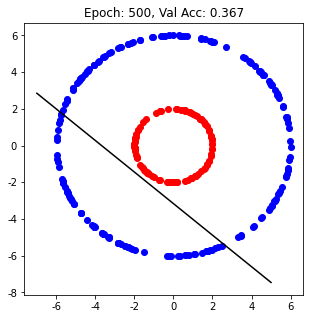

In [276]:
line=np.array(range(-7, 6))
plt.figure(figsize=(5,5))
plt.scatter([i[0] for i in a], [i[1] for i in a], color='red')
plt.scatter([i[0] for i in b], [i[1] for i in b], color='blue')
plt.plot(line, (-weights[0]/weights[1])*line-bias/weights[1], color='black')
plt.title(f'Epoch: {len(val_acc):03d}, Val Acc: {val_acc[-1]:.3f}')

plt.show()

정확도가 0.36 정도로 서의 전혀 맞추지 못하고 있다.

## 3.2 데이터 변환과 Kernel Trick의 의미
원래의 데이터를 3차원의 polynomial kernel을 사용해 변환
 $\varphi\left(\left[\begin{array}{ll}x_1 & x_2\end{array}\right]\right)=\left[\begin{array}{lll}x_1^2 & x_2^2 & \sqrt{2} x_1 x_2\end{array}\right]$

이러한 상황에서 만약 데이터를 위의 식처럼 조작하여 3차원으로 다시 mapping 해본다면 어떨까

In [277]:
#동일한 데이터를 3차원으로 조작
data_polynomial_kernel=pd.DataFrame()
data_polynomial_kernel['x1'] = data['x']**2
data_polynomial_kernel['x2'] = data['y']**2
data_polynomial_kernel['x3'] = math.sqrt(2)*data['x']*data['y']
data_polynomial_kernel['label'] = data['label']

X_train = pd.concat([data_polynomial_kernel[['x1','x2','x3']].iloc[0:70],data_polynomial_kernel[['x1','x2','x3']].iloc[100:240]])
X_test = pd.concat([data_polynomial_kernel[['x1','x2','x3']].iloc[70:100],data_polynomial_kernel[['x1','x2','x3']].iloc[240:300]])
label_train = pd.concat([data_polynomial_kernel['label'].iloc[0:70],data_polynomial_kernel['label'].iloc[100:240]])
label_test = pd.concat([data_polynomial_kernel['label'].iloc[70:100],data_polynomial_kernel['label'].iloc[240:300]])

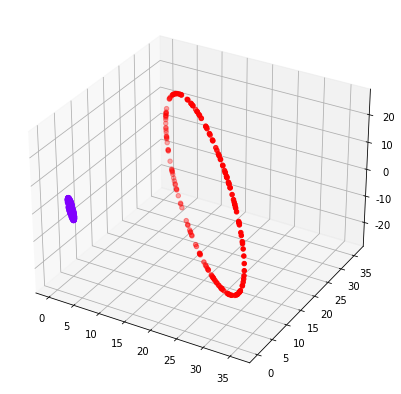

In [290]:
# 동일한 데이터를 3차원으로 조작한 것 만으로 선형 분류기로도 완벽한 분류가 가능

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')

ax.scatter3D(data_polynomial_kernel['x1'], data_polynomial_kernel['x2'],data_polynomial_kernel['x3'], c=data_polynomial_kernel['label'], cmap='rainbow')
plt.show()

위 3차원 그래프에서 확인 할 수 있듯이 이제는 직선의 분류 경계면으로 완벽하게 분류가 가능해 진다.  
현재의 차원에서 앞선 SVM을 적용하여 보자

In [ ]:
# Soft margin SVM
X = data_polynomial_kernel[['x1', 'x2', 'x3']]
y = data_polynomial_kernel['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

weights, bias, train_loss, val_loss, train_acc, val_acc, weights_list, bias_list=train(X_train, y_train, X_val, y_val, 0.01, 10, 300)

바로 분류의 정확도가 1이 나오는 것을 확인 할 수가 있고 그래프로는 다음과 같다.  

3d 그림이기 때문에 분류 경계면이 정말로 데이터를 정확히 분류하였는지 알기가 어렵지만 아래의 그림처럼 보는 각도를 달리하며 살펴보면 완벽하게 분리하고 있다는 것을 확인 할 수 있다.

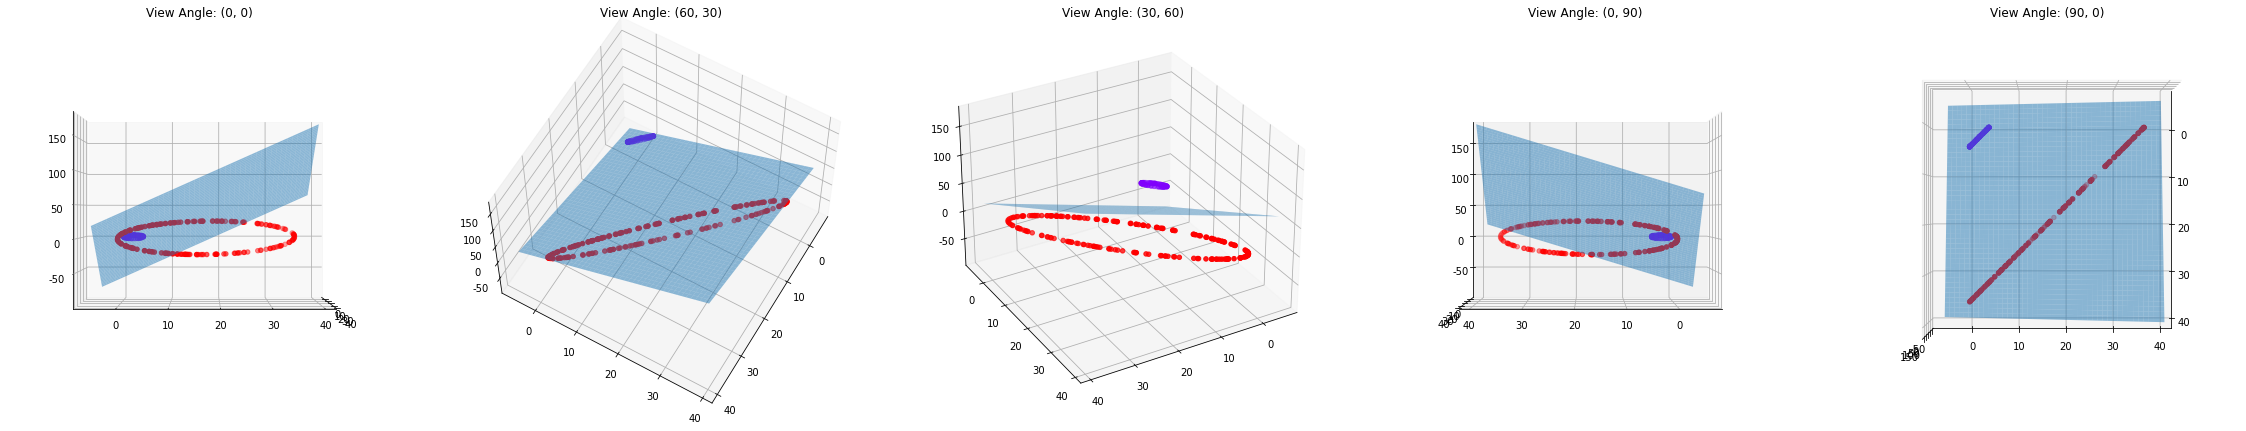

In [300]:
# 동일한 데이터를 3차원으로 조작한 것 만으로 선형 분류기로도 완벽한 분류가 가능
# 그래프 배경화면 만들기
view_angle = [(0,0),(60,30),(30,60),(0,90),(90,0)]
f, axs = plt.subplots(1,5,figsize=(40,10), subplot_kw={"projection":"3d"})

x1,x2=np.meshgrid(range(-5, 40), range(-5, 40))
x3=(-weights[0]*x1-weights[1]*x2-bias)/weights[2]

# 그래프 그리기
for i in range(len(view_angle)):
    axs[int(i%5)].scatter3D(data_polynomial_kernel['x1'], data_polynomial_kernel['x2'],data_polynomial_kernel['x3'], c=data_polynomial_kernel['label'], cmap='rainbow')
    axs[int(i%5)].plot_surface(x1,x2,x3, alpha=0.5)
    axs[int(i%5)].set_title(f'View Angle: {view_angle[i]}')
    axs[int(i%5)].view_init(view_angle[i][0], view_angle[i][1])
plt.show()

방금 전의 예시를 통해 우리는 원래는 선형적으로 분리가 불가능한 데이터라도 적절한 공간에 다시 mapping한다면 선형 분리가 가능하다는 것을 확인 하였다.   

그러나 만약 데이터의 크기가 크고 변형하는 수식이 복잡하다면 이런 변형 자체가 부담이 될 수가 있다.  
여기서 Kernel Trick이 등장하는데 이런 복잡한 계산 과정을 효율적으로 수행할 수 있도록 해준다.  

다음의 최적화 목적식을 보면 우리가 진정으로 필요한 것은 kernel을 통과하여 변환된 데이터가 아니라, 그를 통해 얻은 내적 값에 불과하다. 
<p align="center">
  <image src="images\2022-11-03-21-33-07.png" height="100"/>  
</p>  
<p align="center">
  <image src="images\2022-11-03-21-34-14.png" height="200"/>  
</p> 

결국 Kernel Tric은 데이터에 무조건 Kernel을 적용하여 계산량을 늘리지 말고, Kernel 간 연산의 결과만 알아내서 사용하자는 것이다.

## 3.3 Kernel Trick 구현

다음은 대표적으로 많이 사용되는 kernel을 구현한 것이다.
- Sigmoid Kernel
  -  ![](images\2022-11-03-21-45-15.png)
- Polynomial Kernel
  -  ![](images\2022-11-03-21-45-22.png)
- RBF Kernel(Gaussian Kernel)
  -  ![](images\2022-11-03-21-45-28.png)


In [301]:
def kernel(x1, x2, kernel_type='linear', degree=2):
    if kernel_type=='linear':
        return np.dot(x1, x2.T)
    elif kernel_type=='poly':
        return (np.dot(x1, x2.T)+1)**degree
    elif kernel_type=='rbf':
        return np.exp(-np.linalg.norm(x1-x2)**2/(2*(1**2)))
    else:
        raise ValueError('Kernel type not defined')

## 3.4 라이브러리를 통한 Kernel 비교 실험 수행

In [321]:
from sklearn import svm

# Soft margin SVM
a=genrate_circle_data(2, 0, 0, 100)
b=genrate_circle_data(6, 0, 0, 200)
data= pd.DataFrame(a+b, columns=['x', 'y'])
data['label'] = [-1]*len(a) + [1]*len(b)

X = data[['x', 'y']]
y = data['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [319]:
def compare_kernels(X,y,C):
    h = .02  # step size in the mesh

     # SVM regularization parameter
    svc = svm.SVC(kernel='linear', C=C).fit(X, y)
    print(f'Kernel: linear, Accuracy: {svc.score(X, y):.3f}')
    rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
    print(f'Kernel: rbf, Accuracy: {rbf_svc.score(X, y):.3f}')
    poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
    print(f'Kernel: poly, Accuracy: {poly_svc.score(X, y):.3f}')
    lin_svc = svm.LinearSVC(C=C).fit(X, y)
    print(f'Kernel: LinearSVC, Accuracy: {lin_svc.score(X, y):.3f}')

    # create a mesh to plot in
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

    # title for the plots
    titles = ['SVC with linear kernel',
            'LinearSVC (linear kernel)',
            'SVC with RBF kernel',
            'SVC with polynomial (degree 3) kernel']


    for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        plt.subplot(2, 2, i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

        # Plot also the training points
        plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.coolwarm)
        plt.xlabel('Sepal length')
        plt.ylabel('Sepal width')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        plt.title(titles[i])

    plt.show()

Kernel: linear, Accuracy: 0.667
Kernel: rbf, Accuracy: 1.000
Kernel: poly, Accuracy: 0.667
Kernel: LinearSVC, Accuracy: 0.667


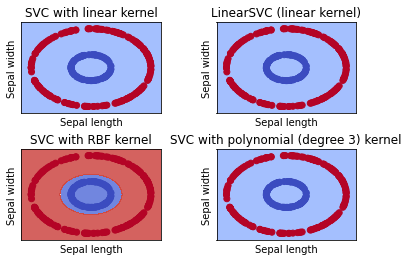

In [320]:
compare_kernels(X,y,1)

이번 데이터의 경우에는 위의 성능에서 확인한 것과 같이 RBF kernel인 경우가 올바른 분류 경계를 만드는 것을 확인 할 수 있다.

Kernel: linear, Accuracy: 0.972
Kernel: rbf, Accuracy: 0.972
Kernel: poly, Accuracy: 0.965
Kernel: LinearSVC, Accuracy: 0.972


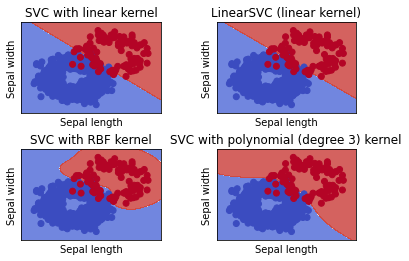

In [322]:
a=np.array(genrate_circle_data(2, 0, 0, 500))
b=np.array(genrate_circle_data(2, 3, 3, 100))

a=a+np.random.standard_normal(a.shape)/2
b=b+np.random.standard_normal(b.shape)/2


data= pd.DataFrame(np.concatenate((a,b)), columns=['x', 'y'])
data['label'] = [-1]*len(a) + [1]*len(b)

X = data[['x', 'y']]
y = data['label']

compare_kernels(X,y,1)

이번 데이터의 경우에는 모든 kernel에서 우수한 성능을 확인하였다.  
즉, 좀 전의 실험과 비교해 보면 데이터에 따라 높은 성능을 보이는 Kernel이 존재할 것이다.  

마지막으로 다양한 데이터에 SVM을 적용했을 때 C에 따라 달라지는 경계면을 보며 이번 튜토리얼을 마무리 해본다.

C: 0.001
Kernel: linear, Accuracy: 0.863
Kernel: rbf, Accuracy: 0.833
Kernel: poly, Accuracy: 0.922
Kernel: LinearSVC, Accuracy: 0.967


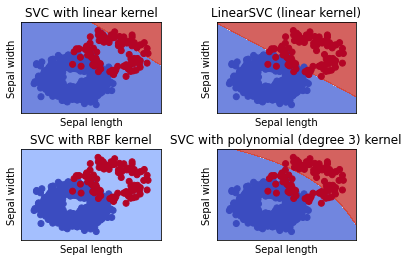

C: 0.01
Kernel: linear, Accuracy: 0.945
Kernel: rbf, Accuracy: 0.833
Kernel: poly, Accuracy: 0.940
Kernel: LinearSVC, Accuracy: 0.952


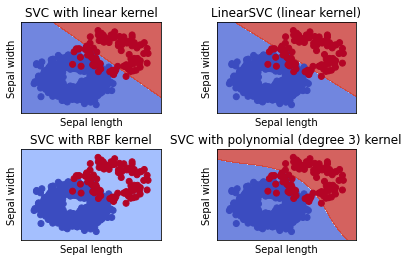

C: 0.1
Kernel: linear, Accuracy: 0.958
Kernel: rbf, Accuracy: 0.962
Kernel: poly, Accuracy: 0.962
Kernel: LinearSVC, Accuracy: 0.957


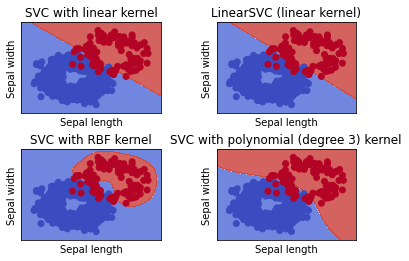

C: 1
Kernel: linear, Accuracy: 0.972
Kernel: rbf, Accuracy: 0.972
Kernel: poly, Accuracy: 0.965
Kernel: LinearSVC, Accuracy: 0.972


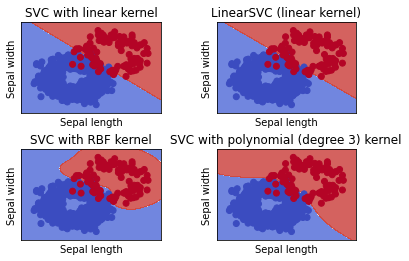

C: 5
Kernel: linear, Accuracy: 0.968
Kernel: rbf, Accuracy: 0.972
Kernel: poly, Accuracy: 0.965
Kernel: LinearSVC, Accuracy: 0.972


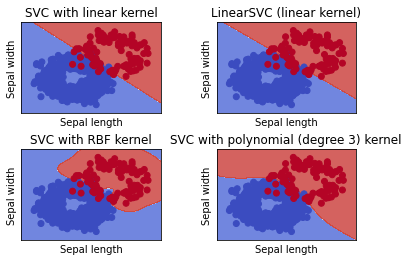

C: 10
Kernel: linear, Accuracy: 0.968
Kernel: rbf, Accuracy: 0.975
Kernel: poly, Accuracy: 0.965
Kernel: LinearSVC, Accuracy: 0.972


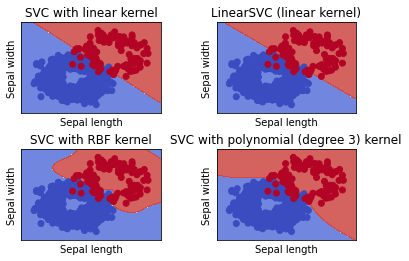

C: 30
Kernel: linear, Accuracy: 0.968
Kernel: rbf, Accuracy: 0.975
Kernel: poly, Accuracy: 0.965
Kernel: LinearSVC, Accuracy: 0.972


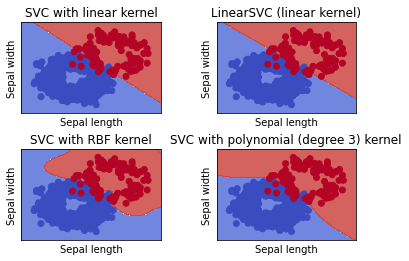

C: 80
Kernel: linear, Accuracy: 0.968
Kernel: rbf, Accuracy: 0.975
Kernel: poly, Accuracy: 0.965
Kernel: LinearSVC, Accuracy: 0.962


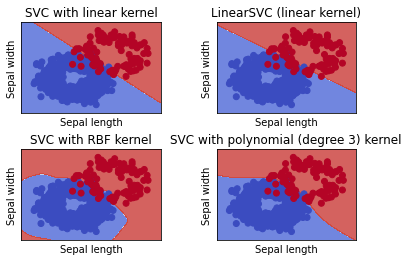

C: 100
Kernel: linear, Accuracy: 0.968
Kernel: rbf, Accuracy: 0.975
Kernel: poly, Accuracy: 0.965
Kernel: LinearSVC, Accuracy: 0.953


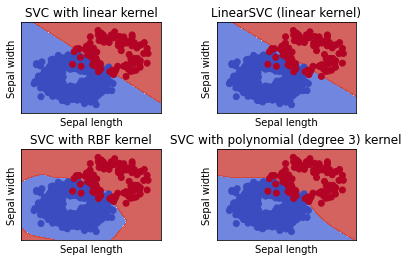

C: 300
Kernel: linear, Accuracy: 0.968
Kernel: rbf, Accuracy: 0.978
Kernel: poly, Accuracy: 0.965
Kernel: LinearSVC, Accuracy: 0.932


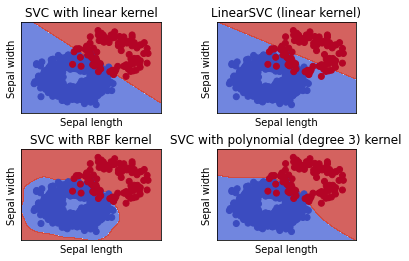

In [324]:
import warnings
warnings.filterwarnings(action='ignore') 

C_list = [0.001, 0.01, 0.1, 1, 5, 10, 30,  80, 100, 300]
for c in C_list:
    print(f'C: {c}')
    compare_kernels(X,y,c)

C: 0.001
Kernel: linear, Accuracy: 0.667
Kernel: rbf, Accuracy: 0.667
Kernel: poly, Accuracy: 0.667
Kernel: LinearSVC, Accuracy: 0.667


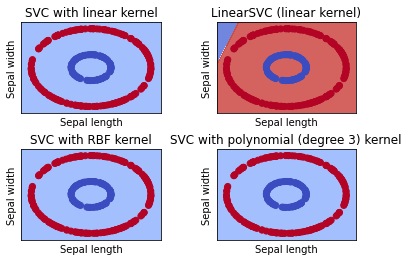

C: 0.01
Kernel: linear, Accuracy: 0.667
Kernel: rbf, Accuracy: 0.667
Kernel: poly, Accuracy: 0.667
Kernel: LinearSVC, Accuracy: 0.667


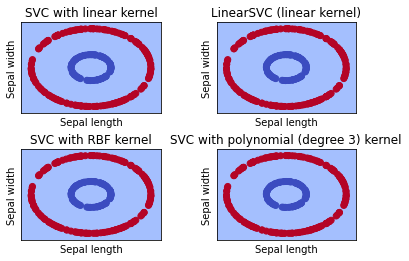

C: 0.1
Kernel: linear, Accuracy: 0.667
Kernel: rbf, Accuracy: 1.000
Kernel: poly, Accuracy: 0.667
Kernel: LinearSVC, Accuracy: 0.667


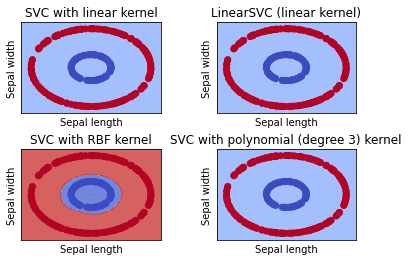

C: 1
Kernel: linear, Accuracy: 0.667
Kernel: rbf, Accuracy: 1.000
Kernel: poly, Accuracy: 0.667
Kernel: LinearSVC, Accuracy: 0.667


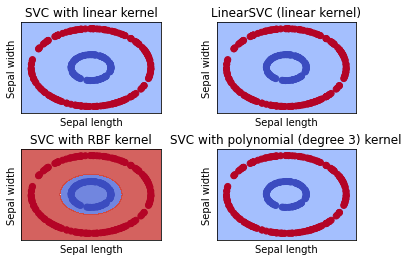

C: 5
Kernel: linear, Accuracy: 0.667
Kernel: rbf, Accuracy: 1.000
Kernel: poly, Accuracy: 0.667
Kernel: LinearSVC, Accuracy: 0.667


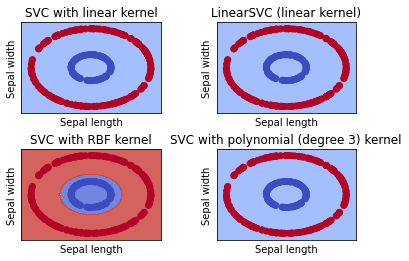

C: 10
Kernel: linear, Accuracy: 0.667
Kernel: rbf, Accuracy: 1.000
Kernel: poly, Accuracy: 0.667
Kernel: LinearSVC, Accuracy: 0.667


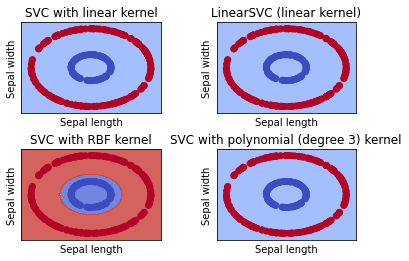

C: 30
Kernel: linear, Accuracy: 0.667
Kernel: rbf, Accuracy: 1.000
Kernel: poly, Accuracy: 0.667
Kernel: LinearSVC, Accuracy: 0.497


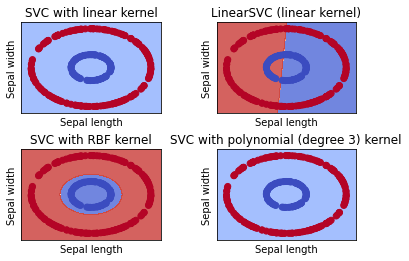

C: 80
Kernel: linear, Accuracy: 0.667
Kernel: rbf, Accuracy: 1.000
Kernel: poly, Accuracy: 0.667
Kernel: LinearSVC, Accuracy: 0.557


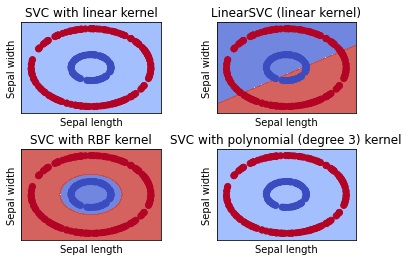

C: 100
Kernel: linear, Accuracy: 0.667
Kernel: rbf, Accuracy: 1.000
Kernel: poly, Accuracy: 0.667
Kernel: LinearSVC, Accuracy: 0.510


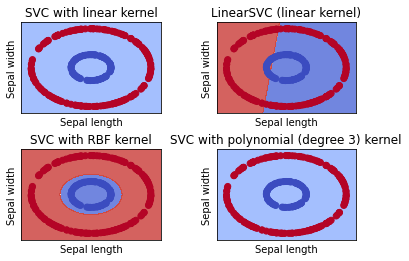

C: 300
Kernel: linear, Accuracy: 0.667
Kernel: rbf, Accuracy: 1.000
Kernel: poly, Accuracy: 0.667
Kernel: LinearSVC, Accuracy: 0.557


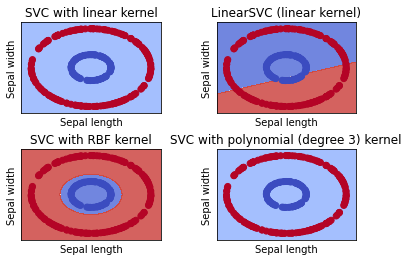

In [325]:
# Soft margin SVM
a=genrate_circle_data(2, 0, 0, 100)
b=genrate_circle_data(6, 0, 0, 200)
data= pd.DataFrame(a+b, columns=['x', 'y'])
data['label'] = [-1]*len(a) + [1]*len(b)

X = data[['x', 'y']]
y = data['label']

C_list = [0.001, 0.01, 0.1, 1, 5, 10, 30,  80, 100, 300]
for c in C_list:
    print(f'C: {c}')
    compare_kernels(X,y,c)

C: 0.001
Kernel: linear, Accuracy: 0.875
Kernel: rbf, Accuracy: 0.880
Kernel: poly, Accuracy: 0.655
Kernel: LinearSVC, Accuracy: 0.830


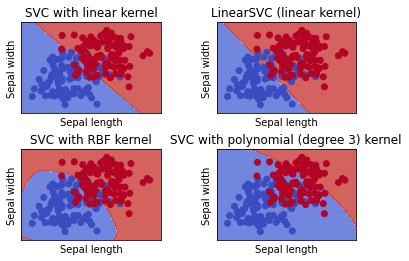

C: 0.01
Kernel: linear, Accuracy: 0.875
Kernel: rbf, Accuracy: 0.880
Kernel: poly, Accuracy: 0.820
Kernel: LinearSVC, Accuracy: 0.865


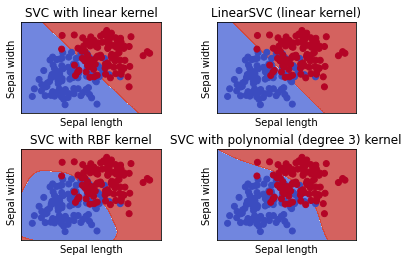

C: 0.1
Kernel: linear, Accuracy: 0.875
Kernel: rbf, Accuracy: 0.880
Kernel: poly, Accuracy: 0.865
Kernel: LinearSVC, Accuracy: 0.885


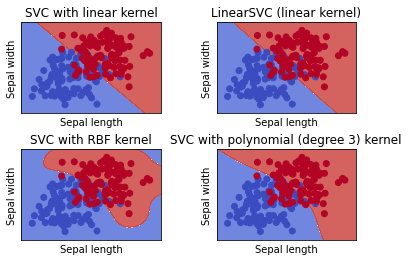

C: 1
Kernel: linear, Accuracy: 0.870
Kernel: rbf, Accuracy: 0.890
Kernel: poly, Accuracy: 0.855
Kernel: LinearSVC, Accuracy: 0.875


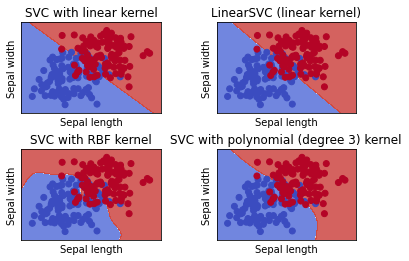

C: 5
Kernel: linear, Accuracy: 0.865
Kernel: rbf, Accuracy: 0.885
Kernel: poly, Accuracy: 0.855
Kernel: LinearSVC, Accuracy: 0.875


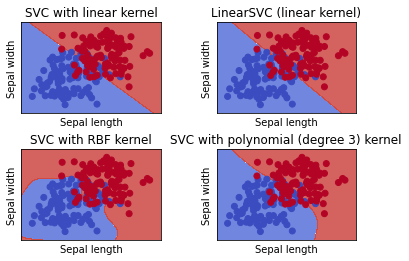

C: 10
Kernel: linear, Accuracy: 0.865
Kernel: rbf, Accuracy: 0.885
Kernel: poly, Accuracy: 0.855
Kernel: LinearSVC, Accuracy: 0.875


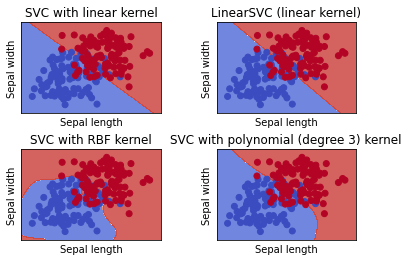

C: 30
Kernel: linear, Accuracy: 0.865
Kernel: rbf, Accuracy: 0.900
Kernel: poly, Accuracy: 0.855
Kernel: LinearSVC, Accuracy: 0.880


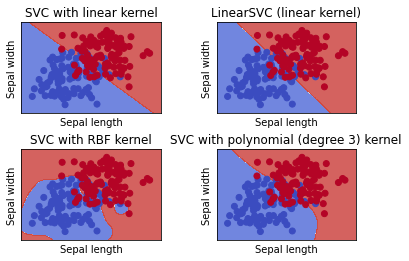

C: 80
Kernel: linear, Accuracy: 0.865
Kernel: rbf, Accuracy: 0.900
Kernel: poly, Accuracy: 0.855
Kernel: LinearSVC, Accuracy: 0.865


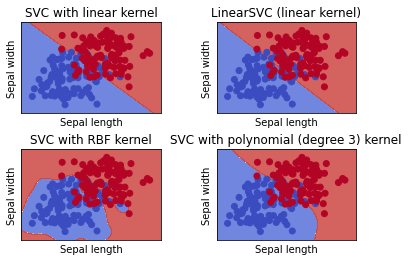

C: 100
Kernel: linear, Accuracy: 0.865
Kernel: rbf, Accuracy: 0.910
Kernel: poly, Accuracy: 0.855
Kernel: LinearSVC, Accuracy: 0.840


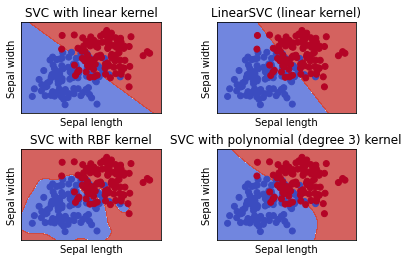

C: 300
Kernel: linear, Accuracy: 0.865
Kernel: rbf, Accuracy: 0.925
Kernel: poly, Accuracy: 0.855
Kernel: LinearSVC, Accuracy: 0.875


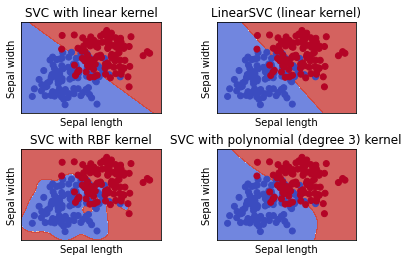

In [326]:
# 실험 데이터 생성
a=np.array(genrate_circle_data(2, 0, 0, 100))
b=np.array(genrate_circle_data(2, 3, 3, 100))

a=a+np.random.standard_normal(a.shape)
b=b+np.random.standard_normal(b.shape)

data= pd.DataFrame(np.concatenate((a,b)), columns=['x', 'y'])
data['label'] = [-1]*len(a) + [1]*len(b)

X = data[['x', 'y']]
y = data['label']

C_list = [0.001, 0.01, 0.1, 1, 5, 10, 30,  80, 100, 300]
for c in C_list:
    print(f'C: {c}')
    compare_kernels(X,y,c)